## Training a Classifier

### Training and testing on CIFAR10 dataset

#### 1. Load and normalize CIFAR10

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

In [2]:
#The output of torchvision datasets are PILImage images of range [0, 1]. We transform them to Tensors of normalized range [-1, 1].

In [2]:
transform = transforms.Compose(
        [transforms.ToTensor(),
        transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))]
)

In [3]:
batch_size = 16

In [4]:
train_data = torchvision.datasets.CIFAR10(
    root = './CIFAR10',
    train = True,
    download = True,
    transform = transform
)

test_data = torchvision.datasets.CIFAR10(
    root = './CIFAR10',
    train = False,
    download = True,
    transform = transform
)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
from torch.utils.data import DataLoader

In [6]:
train_dataloader = DataLoader(train_data,batch_size=batch_size,shuffle=True)
test_dataloader = DataLoader(test_data,batch_size=batch_size,shuffle=False)

In [7]:
train_dataloader.dataset

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./CIFAR10
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

In [8]:
len(train_dataloader)

3125

In [9]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

##### show CIFAR10 dataset

In [10]:
import matplotlib.pyplot as plt
import numpy as np

In [11]:
def img_show(img):
    img = img/2+0.5
    img_np = img.numpy()
    plt.imshow(np.transpose(img_np,(1,2,0)))
    plt.show()    

In [12]:
dataiter = iter(train_dataloader)
images,labels = next(dataiter)

In [13]:
print(images.shape)
print(labels.shape)
print(labels)

torch.Size([16, 3, 32, 32])
torch.Size([16])
tensor([1, 5, 4, 1, 5, 1, 9, 3, 6, 1, 1, 9, 6, 7, 1, 7])


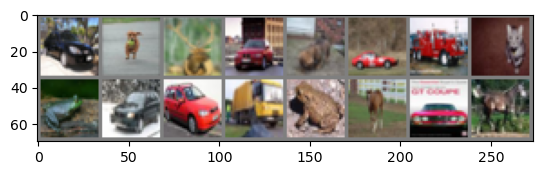

In [14]:
# img_show(torchvision.utils.make_grid(images,2))
img_show(torchvision.utils.make_grid(images))

In [15]:
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

car   dog   deer  car   dog   car   truck cat   frog  car   car   truck frog  horse car   horse


#### 2. Define a Convolutional Neural Network

In [16]:
import torch.nn as nn
import torch.nn.functional as F

In [17]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3,6,5)
        self.pool = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(6,16,5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self,x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x,1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [18]:
net = Net()

#### 3. Define a Loss function and optimizer

In [19]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

#### 4. Train and test the network

In [20]:
#Using GPU to train and test
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net.to(device)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [21]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    running_loss = 0.0
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        X = X.to(device)
        y = y.to(device)
        pred = model(X)
        loss = loss_fn(pred, y)
        running_loss += loss

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 500 == 499:
            avg_batch_loss = running_loss / (batch+1) 
            current = (batch + 1) * len(X)
            print(f"avg_batch_loss: {avg_batch_loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(device)
            y = y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [22]:
epochs = 5

In [23]:
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, net, criterion, optimizer)
    test_loop(test_dataloader, net, criterion)
print("Done!")

Epoch 1
-------------------------------
avg_batch_loss: 2.301789  [ 8000/50000]
avg_batch_loss: 2.296865  [16000/50000]
avg_batch_loss: 2.257265  [24000/50000]
avg_batch_loss: 2.207986  [32000/50000]
avg_batch_loss: 2.148791  [40000/50000]
avg_batch_loss: 2.091182  [48000/50000]
Test Error: 
 Accuracy: 34.9%, Avg loss: 1.746260 

Epoch 2
-------------------------------
avg_batch_loss: 1.703067  [ 8000/50000]
avg_batch_loss: 1.683129  [16000/50000]
avg_batch_loss: 1.657800  [24000/50000]
avg_batch_loss: 1.633737  [32000/50000]
avg_batch_loss: 1.611571  [40000/50000]
avg_batch_loss: 1.589398  [48000/50000]
Test Error: 
 Accuracy: 44.8%, Avg loss: 1.517297 

Epoch 3
-------------------------------
avg_batch_loss: 1.466033  [ 8000/50000]
avg_batch_loss: 1.443492  [16000/50000]
avg_batch_loss: 1.434128  [24000/50000]
avg_batch_loss: 1.423108  [32000/50000]
avg_batch_loss: 1.412016  [40000/50000]
avg_batch_loss: 1.402321  [48000/50000]
Test Error: 
 Accuracy: 49.5%, Avg loss: 1.424670 

Epoc

In [ ]:
train_dataloader = DataLoader(train_data,batch_size=batch_size,shuffle=True)
test_dataloader = DataLoader(test_data,batch_size=batch_size,shuffle=False)

In [131]:
from torchvision.models import resnet18

In [132]:
ResNet18 = resnet18()

In [133]:
ResNet18.fc = nn.Linear(ResNet18.fc.in_features,10)

In [134]:
res_optimizer = optim.Adam(ResNet18.parameters(),lr = 0.0001)

In [135]:
ResNet18.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [136]:
torch.cuda.empty_cache()

In [138]:
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, ResNet18, criterion, res_optimizer)
    test_loop(test_dataloader, ResNet18, criterion)
print("Done!")

Epoch 1
-------------------------------
avg_batch_loss: 1.906707  [ 8000/50000]
avg_batch_loss: 1.775205  [16000/50000]
avg_batch_loss: 1.699885  [24000/50000]
avg_batch_loss: 1.646307  [32000/50000]
avg_batch_loss: 1.600596  [40000/50000]
avg_batch_loss: 1.559157  [48000/50000]
Test Error: 
 Accuracy: 57.0%, Avg loss: 1.217839 

Epoch 2
-------------------------------
avg_batch_loss: 1.234445  [ 8000/50000]
avg_batch_loss: 1.227152  [16000/50000]
avg_batch_loss: 1.221467  [24000/50000]
avg_batch_loss: 1.210747  [32000/50000]
avg_batch_loss: 1.199321  [40000/50000]
avg_batch_loss: 1.186628  [48000/50000]
Test Error: 
 Accuracy: 63.3%, Avg loss: 1.039728 

Epoch 3
-------------------------------
avg_batch_loss: 0.978027  [ 8000/50000]
avg_batch_loss: 0.985718  [16000/50000]
avg_batch_loss: 0.980952  [24000/50000]
avg_batch_loss: 0.983256  [32000/50000]
avg_batch_loss: 0.980826  [40000/50000]
avg_batch_loss: 0.976219  [48000/50000]
Test Error: 
 Accuracy: 65.8%, Avg loss: 0.977457 

Done

In [24]:
#saving net model
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

#### 5. Test the network on the test data

##### show CIFAR10 test dataset

In [26]:
dataiter = iter(test_dataloader)
images, labels = next(dataiter)

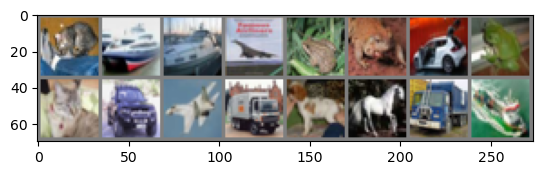

In [28]:
img_show(torchvision.utils.make_grid(images))

In [32]:
print('Test labels:',' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

Test labels: cat   ship  ship  plane frog  frog  car   frog  cat   car   plane truck dog   horse truck ship 


In [33]:
net = Net()

In [34]:
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [35]:
outputs = net(images)

In [37]:
print('predicted labels:',' '.join(f'{classes[j]}' for j in outputs.argmax(1)))

predicted labels: cat ship car ship deer frog car frog dog car deer truck dog horse car ship


In [41]:
labels.size(0)

16

In [58]:
net.eval()

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [64]:
test_loss = 0
num_batch = len(test_dataloader)
correct,total = 0,0
with torch.no_grad():
    for images,r_labels in test_dataloader:
        iamges = images.to(device)
        r_labels = r_labels.to(device)
        preds = net(images).to(device)
        test_loss += criterion(preds,r_labels).item()
        correct += (preds.argmax(1) == r_labels).sum().item()
        total += r_labels.size(0)
print(f'avg_batch_loss: {(test_loss//num_batch):>5f}',f'test_acc: {(100*correct//total):>0.2f}%')

avg_batch_loss: 1.000000 test_acc: 58.00%


##### show each class'accuracy

In [69]:
correct_dict = {classname:0 for classname in classes}
total_dict = {classname:0 for classname in classes}
with torch.no_grad():
    for images,r_labels in test_dataloader:
        iamges = images.to(device)
        r_labels = r_labels.to(device)
        preds = net(images).to(device)
        pred_labels = preds.argmax(1)
        for pred,label in zip(pred_labels,r_labels):
            if pred == label:
                correct_dict[classes[label]] += 1
            total_dict[classes[label]] += 1

In [75]:
for classname, correct_count in correct_dict.items():
    accuracy = 100 * float(correct_count) / total_dict[classname]
    print(f'Accuracy for class: {classname} is {accuracy:0.1f}%')

Accuracy for class: plane is 52.1%
Accuracy for class: car is 80.4%
Accuracy for class: bird is 41.7%
Accuracy for class: cat is 31.3%
Accuracy for class: deer is 54.8%
Accuracy for class: dog is 50.4%
Accuracy for class: frog is 72.2%
Accuracy for class: horse is 68.0%
Accuracy for class: ship is 74.4%
Accuracy for class: truck is 63.4%
